In [1]:
from keras import layers, models
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
import numpy as np

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
print(train_data.shape, train_targets.shape, test_data.shape, test_targets.shape)

(404, 13) (404,) (102, 13) (102,)


In [4]:
len(train_data.mean(axis=0))

13

In [5]:
# use central limit theorem to normalise the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

**Notice that we can't use any knowledge that derive from the train set to test set**

In [6]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

In [7]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model

## K-Fold Cross Validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

In [8]:
# realization of k-fold cross validation

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    # prepare kth partition data
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print(all_scores)
print(np.mean(all_scores))

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
[2.1038992298711645, 2.0762526233597556, 2.943851655072505, 2.3916882984709034]
2.378922951693582


In [9]:
# in order to record how the model perform in each turn,  we need to use a larger epochs
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    # prepare kth partition data
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        epochs=num_epochs, 
                        batch_size=1, 
                        verbose=0,
                       validation_data=(val_data, val_targets))
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
len(all_mae_histories)

4

In [11]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs) ]

In [12]:
len(average_mae_history)

500

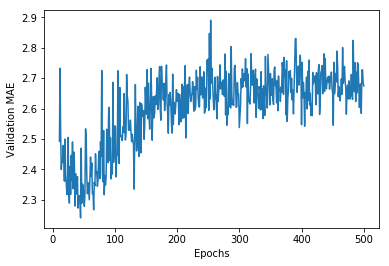

In [13]:
plt.plot(range(1, len(average_mae_history)+1)[10:], average_mae_history[10:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It seems like the first few points are outlier, so we decide to remove them

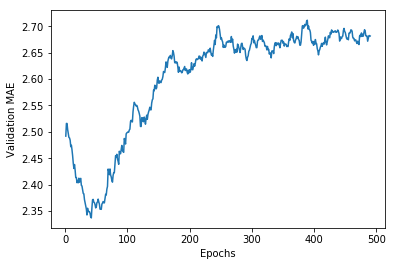

44


In [14]:
# the factor can be a number between 0 and 1. larger, smoother. When factor = 1, the graph will be a flat line.
def smoother(points, factor=0.9):
    res = []
    for point in points:
        if len(res) > 0:
            previous = res[-1]
            res.append(previous * factor + point * (1-factor))
        else:
            res.append(point)
    return res

smooth_mae_history = smoother(average_mae_history[10:])

plt.plot( range(1, len(smooth_mae_history)+1) , smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

print(average_mae_history.index(min(average_mae_history)))

In [15]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=35, batch_size=1, verbose=0)
model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


[15.736847970999923, 2.4893708322562422]

## Summary
- regression normally use **MSE** as loss function
- we evaluated how good is our model by using **MAE** instead of accuracy
- if the input features has different range, we need to normalize it (by using central limit theorem)
- if there is not much avaliable data, use K-fold to validate the model
- less trainning data, less hidden layer to prevent overfitting